# Seasonal Decomposition
Time series analysis is used to identify patterns, trend, and seasonal variations in the data, with this it can be used to forecast future values.

- Seasonal Decomposition of Time Series
- ARIMA/SARIMA Modeling
- Holt-Winter's Exponential Smoothing

The analysis will be done on the following data
- Number of Cars Sold

### Import Packages

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.gridspec as gridspec
from pmdarima import auto_arima
from itertools import product
import warnings

In [3]:
from sklearn.metrics import mean_absolute_error

### Import Functions

#### Plotting Data

In [4]:
#Create a function that plots multiple lines
def plot_multiple_series(xvalue,yvalues,labels,title,xlabel,ylabel):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        plt.plot(xvalue, yvalues[i], label=labels[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
#Create a function for line time series
def line_series(x,y,title,xlabel,ylabel,grid=False):
    plt.figure(figsize=(12,8))
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.show()


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_with_annotated_dates(xvalues, yvalues, events_list, date_of_events_list, xlabel, ylabel, title, line_colors=None):
    plt.figure(figsize=(12, 8))
    plt.plot(xvalues, yvalues, label='Monthly Cars Sold')
    
    # Convert date_of_events_list to datetime
    date_of_events_list = pd.to_datetime(date_of_events_list)
    
    # Default colors if line_colors is not provided
    if line_colors is None:
        line_colors = ['orange', 'red', 'green', 'blue', 'purple', 'brown', 'pink']
    
    for i, (event, date) in enumerate(zip(events_list, date_of_events_list)):
        color = line_colors[i % len(line_colors)]
        plt.axvline(x=date, color=color, linestyle='--', label=event)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Custom function to plot histogram
def plot_histogram(ax, data, bins,title,xlabel,ylabel):
    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

#### Preprocess Data

In [8]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
#Create list of months
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

def create_monthly_data(df,value_column,incrementing_month):

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = (i) // 12
        month = months[(i) % 12]
        monthly_data.at[year,month] = row[value_column]

    return monthly_data

#### ARIMA/SARIMA Modeling

In [9]:
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

def evaluate_time_series_models(data, ar_orders, ma_orders, d_orders):
    results = []

    # Evaluate AR models
    for p in ar_orders:
        try:
            model = ARIMA(data, order=(p, 0, 0)).fit()
            results.append(('AR', (p, 0, 0), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate MA models
    for q in ma_orders:
        try:
            model = ARIMA(data, order=(0, 0, q)).fit()
            results.append(('MA', (0, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARMA models
    for p, q in product(ar_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, 0, q)).fit()
            results.append(('ARMA', (p, 0, q), model.aic, model.bic))
        except Exception as e:
            continue

    # Evaluate ARIMA models
    for p, d, q in product(ar_orders, d_orders, ma_orders):
        try:
            model = ARIMA(data, order=(p, d, q)).fit()
            results.append(('ARIMA', (p, d, q), model.aic, model.bic))
        except Exception as e:
            continue

    result_df = pd.DataFrame(results, columns=['Model', 'Order', 'AIC', 'BIC'])
    return result_df.sort_values(by=['AIC'])

In [10]:
def select_best_sarima_model(data, p_list, d_list, q_list, P_list, D_list, Q_list, s):
   
    # Expand the parameter space for auto_arima to search
    model = auto_arima(data, start_p=min(p_list), d=min(d_list), start_q=min(q_list),
                       max_p=max(p_list), max_d=max(d_list), max_q=max(q_list),
                       start_P=min(P_list), D=min(D_list), start_Q=min(Q_list),
                       max_P=max(P_list), max_D=max(D_list), max_Q=max(Q_list),
                       seasonal=True, m=s, stepwise=True,
                       suppress_warnings=True, trace=False,
                       error_action='ignore', information_criterion='aic')

    # Extract the AIC and BIC from the selected model
    results = {
        'aic': model.aic(),
        'bic': model.bic(),
        'pdq': model.order,
        'seasonal_pdq': model.seasonal_order
    }
   
    return results

In [11]:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

#### Probability

In [12]:
from scipy.stats import norm, lognorm

def generate_numbers_from_distribution(distribution, params, size, range_min, range_max, seed=None):
    """
    Generate numbers from a given distribution within a specified range.

    Parameters:
    - distribution (str): The type of distribution ('normal', 'lognormal', etc.).
    - params (tuple): Parameters for the distribution.
        - For 'normal': (mean, std_dev)
        - For 'lognormal': (mean, sigma)
    - size (int): Number of random numbers to generate.
    - range_min (float): Minimum value of the range.
    - range_max (float): Maximum value of the range.
    - seed (int, optional): Seed for the random number generator. Default is None.

    Returns:
    - numpy.ndarray: Array of generated numbers within the specified range.
    """
    
    if seed is not None:
        np.random.seed(seed)
    
    if distribution == 'normal':
        mean, std_dev = params
        data = np.random.normal(mean, std_dev, size)
    
    elif distribution == 'lognormal':
        mean, sigma = params
        data = np.random.lognormal(mean, sigma, size)
    
    else:
        raise ValueError("Unsupported distribution type.")
    
    # Filter the data to fall within the specified range
    filtered_data = data[(data >= range_min) & (data <= range_max)]
    
    return filtered_data

### Import Key Data

In [13]:
# import prepared data
data = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/sales_data.csv')

# sales_data
sales_data = data[['date','total_cars_sold']].copy()

# convert date to dtype datetime
sales_data['date'] = pd.to_datetime(sales_data['date'])

sales_data

,date,total_cars_sold
0,2002-01-01,81033
1,2002-02-01,78502
2,2002-03-01,93019
3,2002-04-01,96269
4,2002-05-01,97936
...,...,...
259,2023-08-01,78601
260,2023-09-01,69278
261,2023-10-01,69248
262,2023-11-01,64980


## Total Cars Sold Time Series Analysis

### Seasonal Decomposition of Total Cars Sold
The first time series method is seasonal decomposition which breaks the relevant components of the data into relevant categories which can then be extrapolated based on the historical data.

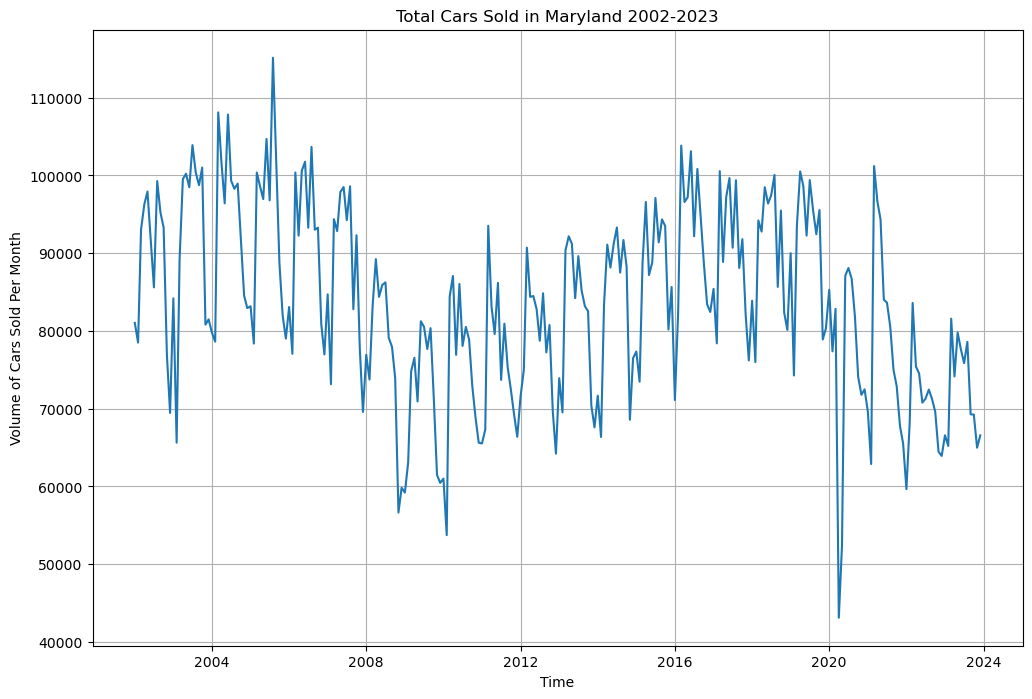

In [14]:
# create a line series graph of total cars sold in Maryland
line_series(sales_data['date'],sales_data['total_cars_sold'],
            'Total Cars Sold in Maryland 2002-2023',
            'Time',
            'Volume of Cars Sold Per Month',True)

Seasonality: There are months with lower units cars sold which is observe by the sharp dips and following increase within calendar years

Irregularities: There are massive oscillations that take place following the turn of 2020 (likely due to Covid-19)

Cyclical: There are periods of downturns and recoveries

Trend: There does not seem to be any clear line trend in the data

#### Seasonality of Total Cars Sold
The first component of total cars sold is the seasonality. By understanding how the average of cars sold changes from month to month will be useful to understand when most cars are sold throuhgout the year. It is also will be an important aspect to understand when forecasting sales. This should be the first step as it takes away a lot of the noise that takes place throughout the year and tries to focus on the overall movement of data instead.

In [15]:
# get the monthly mean values of cars sold
monthly_sales_data = create_monthly_data(sales_data,'total_cars_sold',sales_data.index)
monthly_sales_data

,January,February,March,April,May,June,July,August,September,October,November,December
0,81033,78502,93019,96269,97936,91763,85602,99275,95225,93296,76878,69455
1,84188,65633,89218,99538,100214,98477,103899,100385,98743,101014,80810,81491
2,79788,78622,108106,101537,96408,107831,99323,98281,98950,91885,84513,82941
3,83171,78373,100365,98586,96956,104695,96794,115136,101850,88759,81968,79016
4,83076,77060,100372,92247,100611,101757,93273,103667,93018,93279,80914,76976
5,84707,73153,94375,92833,97875,98508,94250,98596,82789,92313,77753,69581
6,76929,73756,83096,89237,84374,85912,86243,79121,77957,73943,56645,59831
7,59217,63087,74792,76536,70930,81241,80529,77683,80353,71500,61485,60464
8,61007,53741,84430,87073,76931,86042,78070,80517,78891,72914,68826,65625
9,65531,67327,93524,83166,79599,86187,73703,80930,75334,72493,69217,66386


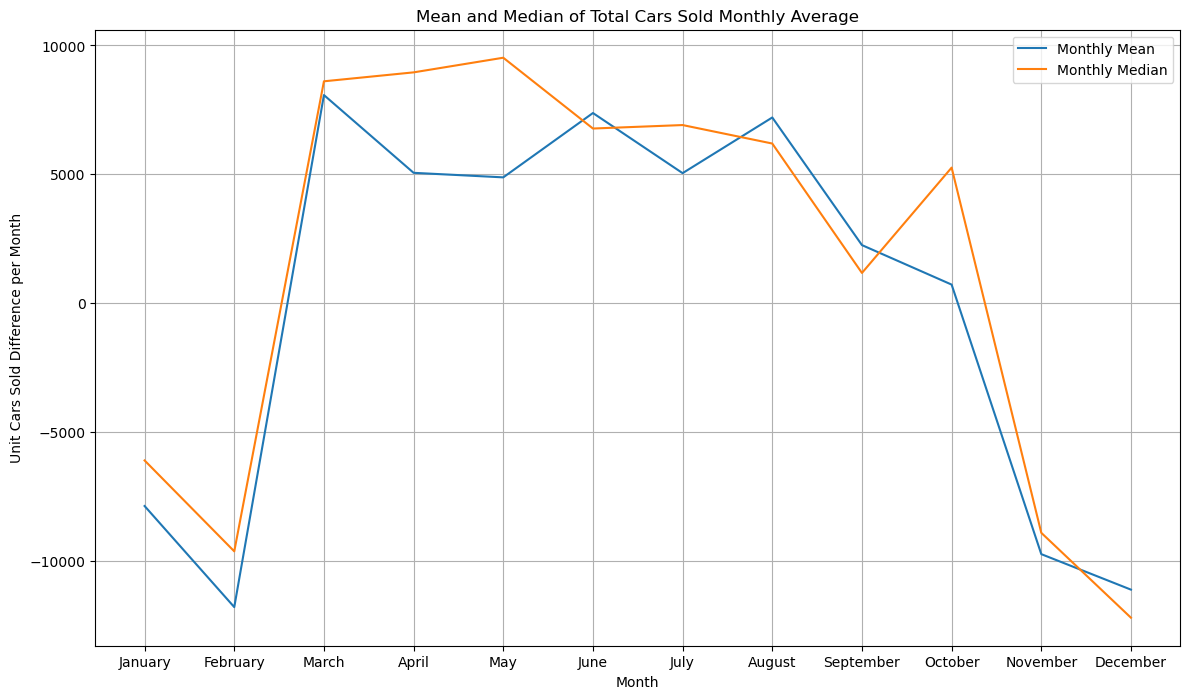

In [16]:
# get the monthly mean of the total cars sold in Maryland
monthly_mean = monthly_sales_data.mean()  - sales_data['total_cars_sold'].mean()

# get the monthly median of total cars sold in Maryland
monthly_median = monthly_sales_data.median() - sales_data['total_cars_sold'].median()

# plot the monthly mean and median data for each month across the 22 years of collected data
plot_multiple_series(months,
                     [monthly_mean,monthly_median],
                     ['Monthly Mean','Monthly Median'],
                     'Mean and Median of Total Cars Sold Monthly Average',
                     'Month',
                     'Unit Cars Sold Difference per Month')

This visual portrays the following information:

In January, February, November and December on average there are about 10000 cars sold less in those months compared to the average across the year. While March through September sells about 5000 cars more per month on average more than the average throughout the year. 

The mean is far lower in April and May than the median which suggests that there have been a few years which have had far lower than expected sales within those specific months. This should be explored before deseasonlising the data.

##### Irregularities in Total Cars Sold
The goal of seasonality is to make sure that the median and the mean are as close together as possible. The contrary results in inaccuracies in forecasting based off the historical data. The below will explore irregularities that exist both on a year to year and month to month basis.

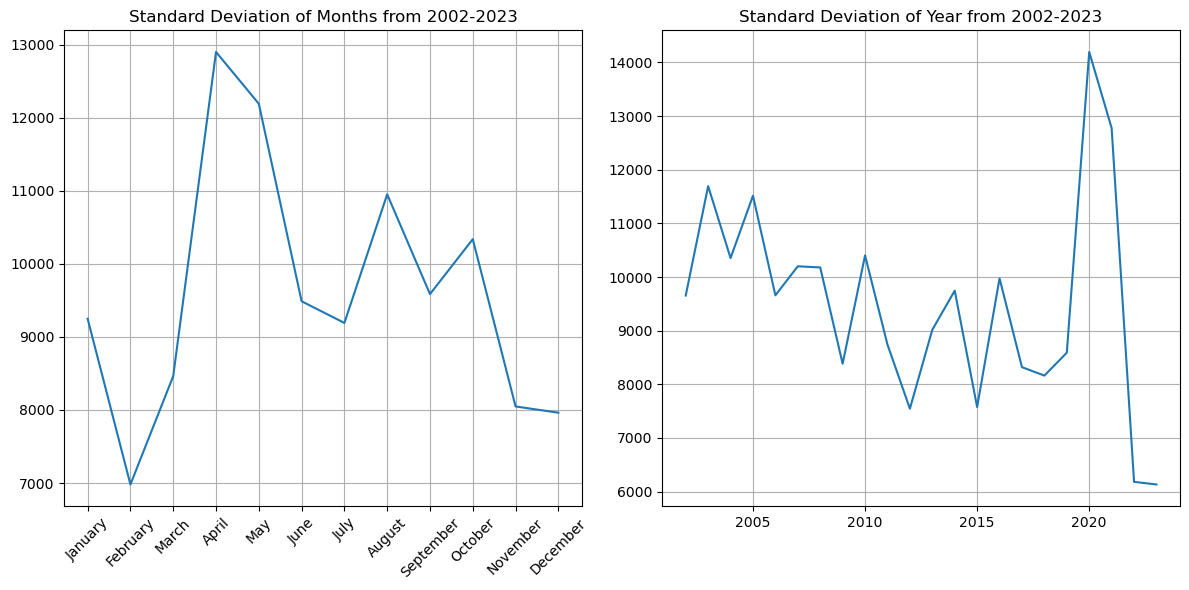

In [17]:
fig,axes = plt.subplots(1,2,figsize=(12,6))

# get the standard deviation of month to month
axes[0].plot(months,monthly_sales_data.std(axis=0))
axes[0].set_title('Standard Deviation of Months from 2002-2023')
axes[0].grid()

# get the standard deviation from year to year
axes[1].plot(range(2002,len(monthly_sales_data)+2002), monthly_sales_data.std(axis=1))
axes[1].set_title('Standard Deviation of Year from 2002-2023')
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)
axes[1].grid()

plt.tight_layout()

Left Image: The image displays the standard deviation for the monthly values collected over the years. It seems to be that in April, May there seems to be larger standard deviations.

Right Image: The image displays the standard deviation from year to year. This shows that the std was actually decreasing from 2002 up until 2020 where there was a massive spike which followed in 2021 before going back on track to 2023.

Information:

April and May have the greatest standard deviation which follows well with what was observed in comparing the mean and the median of the total cars sold.

Covid-19 had a massive impact on expected sales in 2020 and continuing into 2021.

##### Remove Covid-19 influenced data from Total Cars Sold
By removing the sales that took place in 2020 and 2021 based off of the extremely high standard deviation and skewed results as seen throughout this data exploration, it should reduce the issues that the data is bringing to understand the overall trend of the data.

In [18]:
# remove the data falling between calendar years 2020 and 2021
sales_data_covid_removed = sales_data[(sales_data['date'] <= '2020-01-01') | (sales_data['date']>'2022-01-01')].reset_index(drop=True).copy()
sales_data_covid_removed

,date,total_cars_sold
0,2002-01-01,81033
1,2002-02-01,78502
2,2002-03-01,93019
3,2002-04-01,96269
4,2002-05-01,97936
...,...,...
235,2023-08-01,78601
236,2023-09-01,69278
237,2023-10-01,69248
238,2023-11-01,64980


In [19]:
# create monthly data based where the 2020 and 2021 is removed
# the goal is to get a better trend of the data
monthly_sales_data_covid_removed = create_monthly_data(sales_data_covid_removed,'total_cars_sold',sales_data_covid_removed.index)
monthly_sales_data_covid_removed

,January,February,March,April,May,June,July,August,September,October,November,December
0,81033,78502,93019,96269,97936,91763,85602,99275,95225,93296,76878,69455
1,84188,65633,89218,99538,100214,98477,103899,100385,98743,101014,80810,81491
2,79788,78622,108106,101537,96408,107831,99323,98281,98950,91885,84513,82941
3,83171,78373,100365,98586,96956,104695,96794,115136,101850,88759,81968,79016
4,83076,77060,100372,92247,100611,101757,93273,103667,93018,93279,80914,76976
5,84707,73153,94375,92833,97875,98508,94250,98596,82789,92313,77753,69581
6,76929,73756,83096,89237,84374,85912,86243,79121,77957,73943,56645,59831
7,59217,63087,74792,76536,70930,81241,80529,77683,80353,71500,61485,60464
8,61007,53741,84430,87073,76931,86042,78070,80517,78891,72914,68826,65625
9,65531,67327,93524,83166,79599,86187,73703,80930,75334,72493,69217,66386


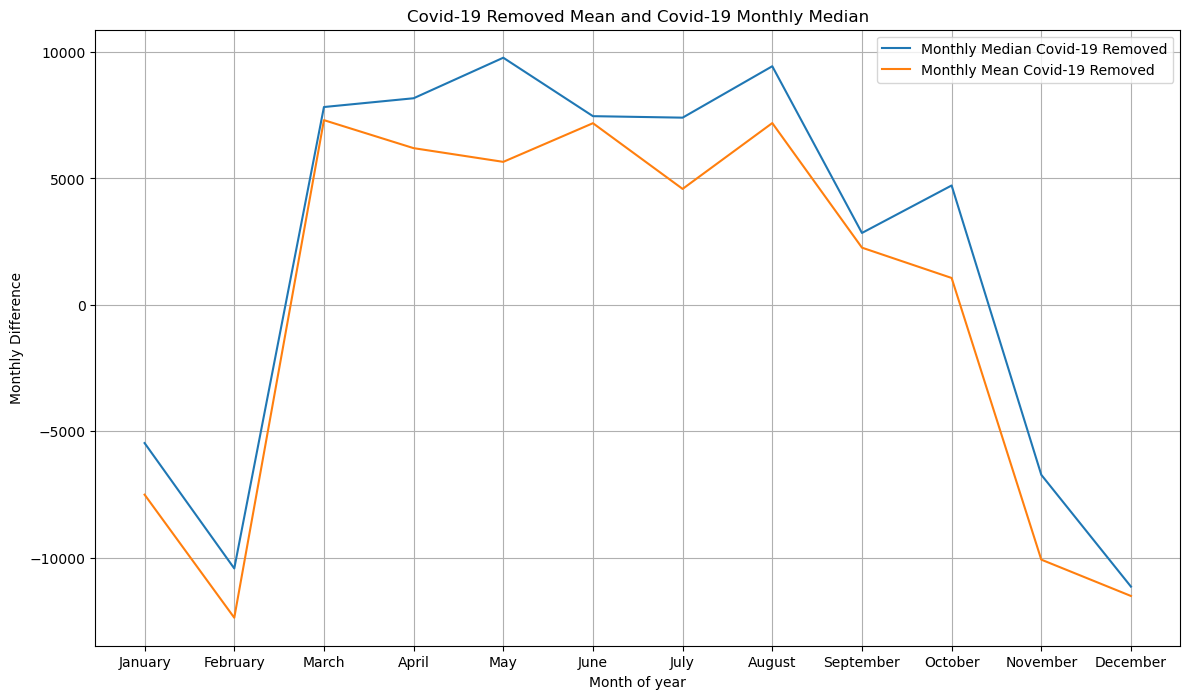

In [20]:
# get the mean of each month where 2020 and 2021 data has been removed
monthly_mean_covid_removed = monthly_sales_data_covid_removed.mean() - sales_data_covid_removed['total_cars_sold'].mean()

# get the meedian of each month where 2020 and 2021 data has been removede
monthly_median_covid_removed = monthly_sales_data_covid_removed.median() - sales_data_covid_removed['total_cars_sold'].median()

plot_multiple_series(months,[monthly_median_covid_removed,monthly_mean_covid_removed],
                     ['Monthly Median Covid-19 Removed','Monthly Mean Covid-19 Removed'],
                     'Covid-19 Removed Mean and Covid-19 Monthly Median',
                     'Month of year',
                     'Monthly Difference')

The difference between mean and median is improved. They both follow the same movement and their distances are smaller. This has been done by removing the covid-19 data from 2020 and 2021 as it reduces the impact of the far below average sales. 

##### Deseasonalise total cars sold
The goal of deseasonlising the data is to reduce the changes that take place from month to month within a calendar year. This is might be due to the sales changing based on cyclical patterns such as less people buying cars in the colder months in the year. By deseasonlising the data the goal is to remove a component that makes up number of cars sold. This should help isolate cyclical and linear movements.

In [21]:
# create a dataframe of the sales data which will modify the cars sold column
deseasonlise_cars_sold = sales_data.copy()

# get the month based off the date column
deseasonlise_cars_sold['month'] = deseasonlise_cars_sold['date'].dt.month_name()

deseasonlise_cars_sold

,date,total_cars_sold,month
0,2002-01-01,81033,January
1,2002-02-01,78502,February
2,2002-03-01,93019,March
3,2002-04-01,96269,April
4,2002-05-01,97936,May
...,...,...,...
259,2023-08-01,78601,August
260,2023-09-01,69278,September
261,2023-10-01,69248,October
262,2023-11-01,64980,November


In [22]:
# create columns which holds the mean and median values to deseasonlise the data
print(f'Monthly Mean Values: \n{monthly_mean_covid_removed}')
print(f'Monthly Median Values: \n{monthly_median_covid_removed}')

# map the dictionary values based on where the date matches the dictionary index
deseasonlise_cars_sold['monthly_mean_seasonal_component'] = deseasonlise_cars_sold['month'].map(monthly_mean_covid_removed)
deseasonlise_cars_sold['monthly_median_seasonal_component'] = deseasonlise_cars_sold['month'].map(monthly_median_covid_removed)

deseasonlise_cars_sold

Monthly Mean Values: 
January      -7505.304167
February    -12372.354167
March         7308.295833
April         6200.295833
May           5657.995833
June          7187.245833
July          4588.695833
August        7192.195833
September     2264.895833
October       1065.645833
November    -10075.254167
December    -11512.354167
dtype: float64
Monthly Median Values: 
January      -5464.5
February    -10423.5
March         7827.0
April         8174.0
May           9777.0
June          7465.5
July          7406.5
August        9440.0
September     2846.0
October       4724.0
November     -6720.0
December    -11142.5
dtype: float64


,date,total_cars_sold,month,monthly_mean_seasonal_component,monthly_median_seasonal_component
0,2002-01-01,81033,January,-7505.304167,-5464.5
1,2002-02-01,78502,February,-12372.354167,-10423.5
2,2002-03-01,93019,March,7308.295833,7827.0
3,2002-04-01,96269,April,6200.295833,8174.0
4,2002-05-01,97936,May,5657.995833,9777.0
...,...,...,...,...,...
259,2023-08-01,78601,August,7192.195833,9440.0
260,2023-09-01,69278,September,2264.895833,2846.0
261,2023-10-01,69248,October,1065.645833,4724.0
262,2023-11-01,64980,November,-10075.254167,-6720.0


'monthly_mean_seasonal_component' includes the average across the year where as 'monthly_median_seasonal_component' is the isolated difference that happens based on the month of the year. There is a clear correlation between the month and the number of sales.

In [23]:
# deseasonlise total cars sold based on the median of each month
deseasonlise_cars_sold['total_cars_sold_median_deseasonlised'] = deseasonlise_cars_sold['total_cars_sold'] - deseasonlise_cars_sold['monthly_median_seasonal_component']

# deseasonlise total cars sold based on the mean of each month
deseasonlise_cars_sold['total_cars_sold_mean_deseasonlised'] = deseasonlise_cars_sold['total_cars_sold'] - deseasonlise_cars_sold['monthly_mean_seasonal_component']

deseasonlise_cars_sold

,date,total_cars_sold,month,monthly_mean_seasonal_component,monthly_median_seasonal_component,total_cars_sold_median_deseasonlised,total_cars_sold_mean_deseasonlised
0,2002-01-01,81033,January,-7505.304167,-5464.5,86497.5,88538.304167
1,2002-02-01,78502,February,-12372.354167,-10423.5,88925.5,90874.354167
2,2002-03-01,93019,March,7308.295833,7827.0,85192.0,85710.704167
3,2002-04-01,96269,April,6200.295833,8174.0,88095.0,90068.704167
4,2002-05-01,97936,May,5657.995833,9777.0,88159.0,92278.004167
...,...,...,...,...,...,...,...
259,2023-08-01,78601,August,7192.195833,9440.0,69161.0,71408.804167
260,2023-09-01,69278,September,2264.895833,2846.0,66432.0,67013.104167
261,2023-10-01,69248,October,1065.645833,4724.0,64524.0,68182.354167
262,2023-11-01,64980,November,-10075.254167,-6720.0,71700.0,75055.254167


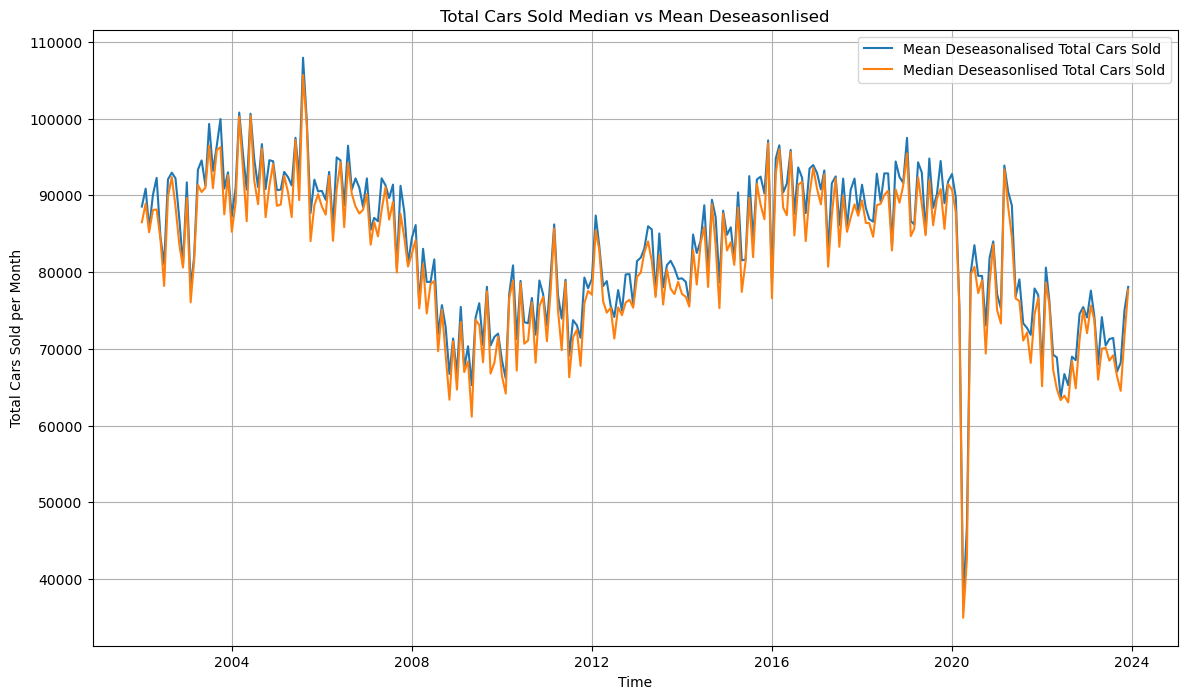

In [24]:
# plot the difference in the data
plot_multiple_series(deseasonlise_cars_sold['date'],
                     [deseasonlise_cars_sold['total_cars_sold_mean_deseasonlised'],deseasonlise_cars_sold['total_cars_sold_median_deseasonlised']],
                      ['Mean Deseasonalised Total Cars Sold', 'Median Deseasonlised Total Cars Sold'],
                      'Total Cars Sold Median vs Mean Deseasonlised',
                      'Time',
                      'Total Cars Sold per Month')

The goal of deseasonlising is to reduce the volitality from month to month. This will require reducing the extent of oscillations from moto month. The data looks that the mean deseasonlisation had reduced the volitality from month to month. 

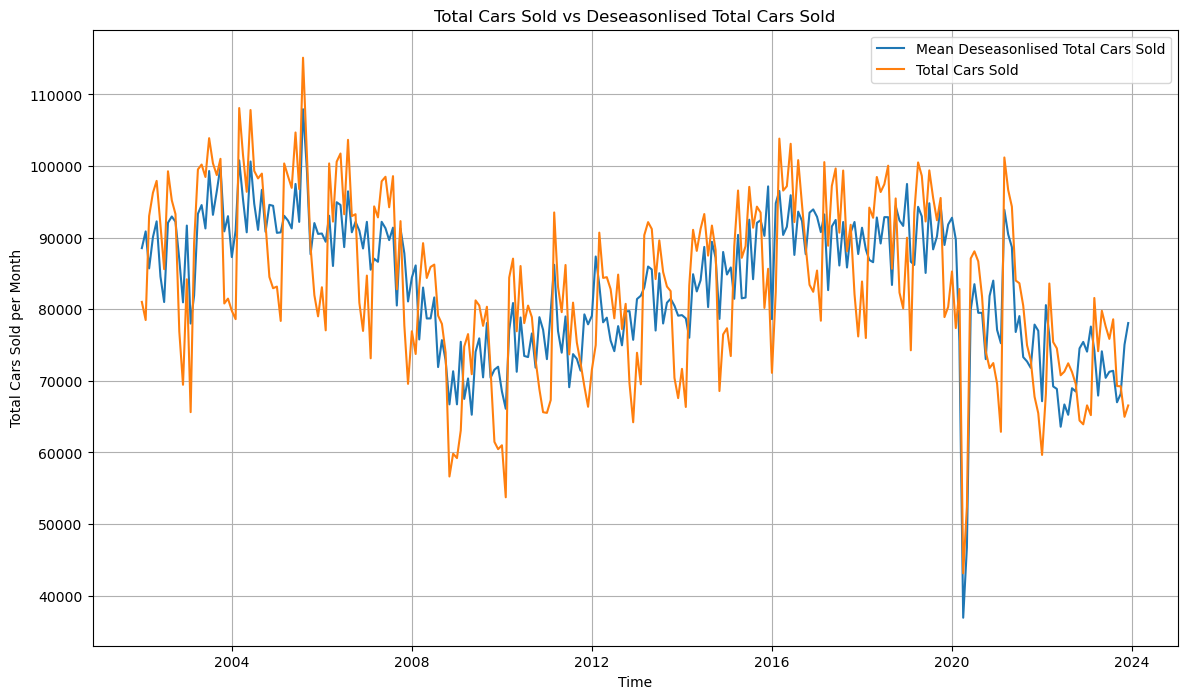

In [25]:
# compare the original cars sold to deseasonlisation of the mean
plot_multiple_series(deseasonlise_cars_sold['date'],
                     [deseasonlise_cars_sold['total_cars_sold_mean_deseasonlised'],deseasonlise_cars_sold['total_cars_sold']],
                      ['Mean Deseasonlised Total Cars Sold', 'Total Cars Sold'],
                      'Total Cars Sold vs Deseasonlised Total Cars Sold',
                      'Time',
                      'Total Cars Sold per Month')

The deseasonlised data has irregularities, cylical changes and linear trends to remove until the decomposition is finsihed. However you can observe that the decomposition has taken away the volitality that takes place within months by deseasonlising the data.

In [26]:
# save the data as deseasonlised data
deseasonlise_cars_sold.drop(columns={'month','monthly_median_seasonal_component','total_cars_sold_median_deseasonlised'},inplace=True)
deseasonlise_cars_sold.rename(columns={'monthly_mean_seasonal_component':'seasonal_component','total_cars_sold_mean_deseasonlised':'total_cars_sold_deseasonlise'},inplace=True)
deseasonlise_cars_sold.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/car_datasets/deseasonlised_sales_data.csv')

#### Irregularities of Total Cars Sold
The next step is to remove irregularities within the data, these are most observed in the years following 2020 due to the economic conditions. Most noticeably in April and May of 2020 where the number of cars sold are historically large dips in sales.

In [27]:
irregularities_cars_sold = deseasonlise_cars_sold.copy()
irregularities_cars_sold[irregularities_cars_sold['date'].dt.year == 2020]

,date,total_cars_sold,seasonal_component,total_cars_sold_deseasonlise
216,2020-01-01,85281,-7505.304167,92786.304167
217,2020-02-01,77376,-12372.354167,89748.354167
218,2020-03-01,82836,7308.295833,75527.704167
219,2020-04-01,43120,6200.295833,36919.704167
220,2020-05-01,52407,5657.995833,46749.004167
221,2020-06-01,87099,7187.245833,79911.754167
222,2020-07-01,88095,4588.695833,83506.304167
223,2020-08-01,86700,7192.195833,79507.804167
224,2020-09-01,81768,2264.895833,79503.104167
225,2020-10-01,74105,1065.645833,73039.354167


In [28]:
# get the average for 2020 seasonlise it for April and May and then replace them
april_covid = monthly_sales_data.iloc[18].mean() + monthly_mean_covid_removed.iloc[3] # the 1st is the average for 2020 the second is the average for april
may_covid =  monthly_sales_data.iloc[18].mean() + monthly_mean_covid_removed.iloc[4] # the 1st is the average for 2020, the second is the average for may

print(april_covid)
print(may_covid)

81455.29583333334
80912.99583333333


In [29]:
# create new columns that can be used to isolate the changes that will take place from removing irregularities
irregularities_cars_sold['irregularities_removed_cars_sold'] = irregularities_cars_sold['total_cars_sold']
irregularities_cars_sold['irregularities_removed_deseasonlised_cars_sold'] = irregularities_cars_sold['total_cars_sold_deseasonlise']
irregularities_cars_sold

,date,total_cars_sold,seasonal_component,total_cars_sold_deseasonlise,irregularities_removed_cars_sold,irregularities_removed_deseasonlised_cars_sold
0,2002-01-01,81033,-7505.304167,88538.304167,81033,88538.304167
1,2002-02-01,78502,-12372.354167,90874.354167,78502,90874.354167
2,2002-03-01,93019,7308.295833,85710.704167,93019,85710.704167
3,2002-04-01,96269,6200.295833,90068.704167,96269,90068.704167
4,2002-05-01,97936,5657.995833,92278.004167,97936,92278.004167
...,...,...,...,...,...,...
259,2023-08-01,78601,7192.195833,71408.804167,78601,71408.804167
260,2023-09-01,69278,2264.895833,67013.104167,69278,67013.104167
261,2023-10-01,69248,1065.645833,68182.354167,69248,68182.354167
262,2023-11-01,64980,-10075.254167,75055.254167,64980,75055.254167


In [30]:
# replace April 2020 with the calculated from above
irregularities_cars_sold.loc[irregularities_cars_sold['date']=='2020-04-01',['irregularities_removed_cars_sold','irregularities_removed_deseasonlised_cars_sold']] = april_covid

In [31]:
# replace May 2020 with the calculated from above
irregularities_cars_sold.loc[irregularities_cars_sold['date']=='2020-05-01',['irregularities_removed_cars_sold','irregularities_removed_deseasonlised_cars_sold']] = may_covid

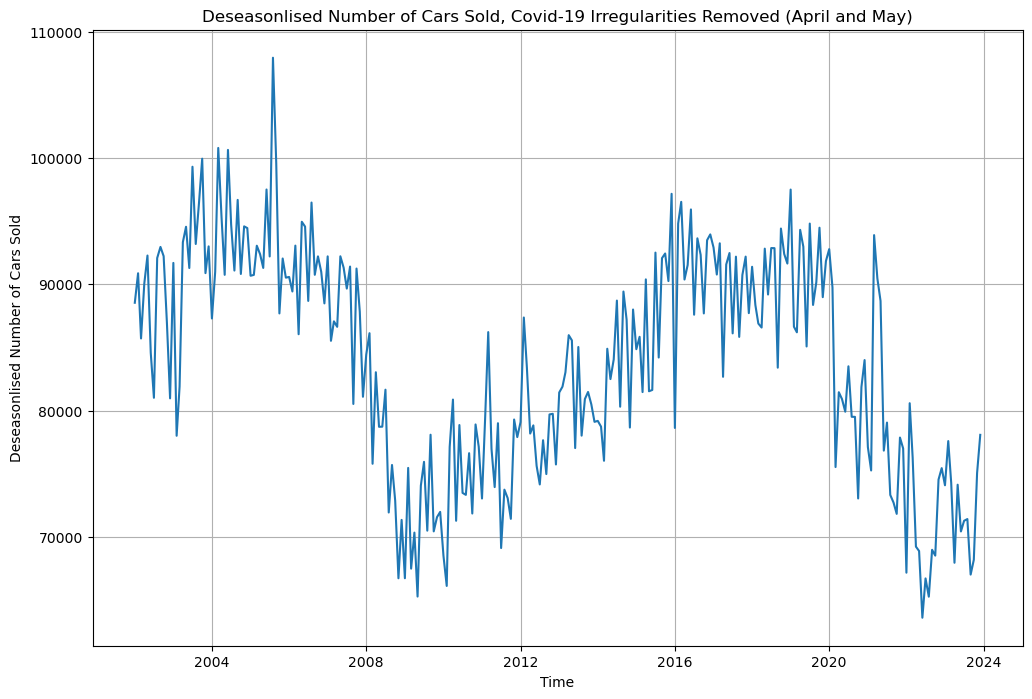

In [32]:
line_series(irregularities_cars_sold['date'],irregularities_cars_sold['irregularities_removed_deseasonlised_cars_sold'],
            'Deseasonlised Number of Cars Sold, Covid-19 Irregularities Removed (April and May)',
            'Time','Deseasonlised Number of Cars Sold',True) 

There is a large spike that takes place in the first period of stagnent growth around 2006. This should be dealt with in a similar manner to what took place during Covid-19. These dates will be recorded but for the sake of forecasting and understanding trends they will be removed.

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_26732/828908897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  irregularities_cars_sold['irregularities_removed_deseasonlised_cars_sold'].iloc[43] = monthly_sales_data.iloc[2].mean() + monthly_mean.iloc[5]


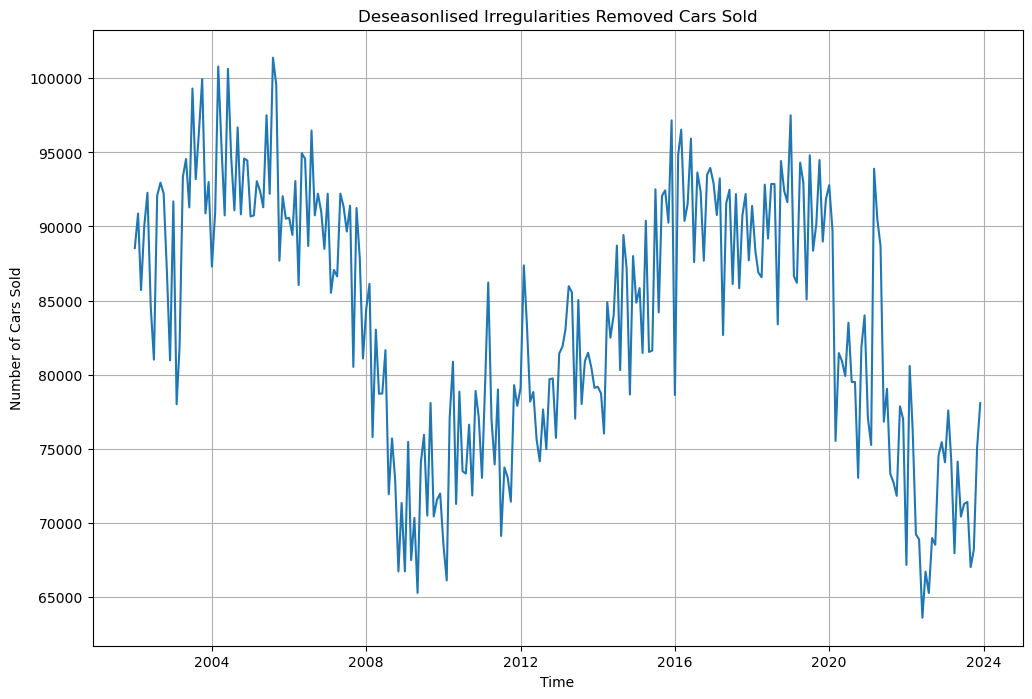

In [33]:
# the location of the spike is at the 44th row entry
irregularities_cars_sold['irregularities_removed_deseasonlised_cars_sold'].iloc[43] = monthly_sales_data.iloc[2].mean() + monthly_mean.iloc[5]
irregularities_cars_sold.rename(columns={'irregularities_removed_deseasonlised_cars_sold':'irregularities_deseasonlised_cars_sold'},inplace=True)
line_series(irregularities_cars_sold['date'],irregularities_cars_sold['irregularities_deseasonlised_cars_sold'],'Deseasonlised Irregularities Removed Cars Sold',
            'Time','Number of Cars Sold',True) 

Observe that the Covid-19 impact irregularities in April and May have been removed. This is because it went away from what was expected within a cycle, it was also a large anomaly due to Economic conditions which will be explored in later chapters.

#### Cyclical of Total Cars Sold

In [34]:
cyclical_cars_sold = irregularities_cars_sold.copy()

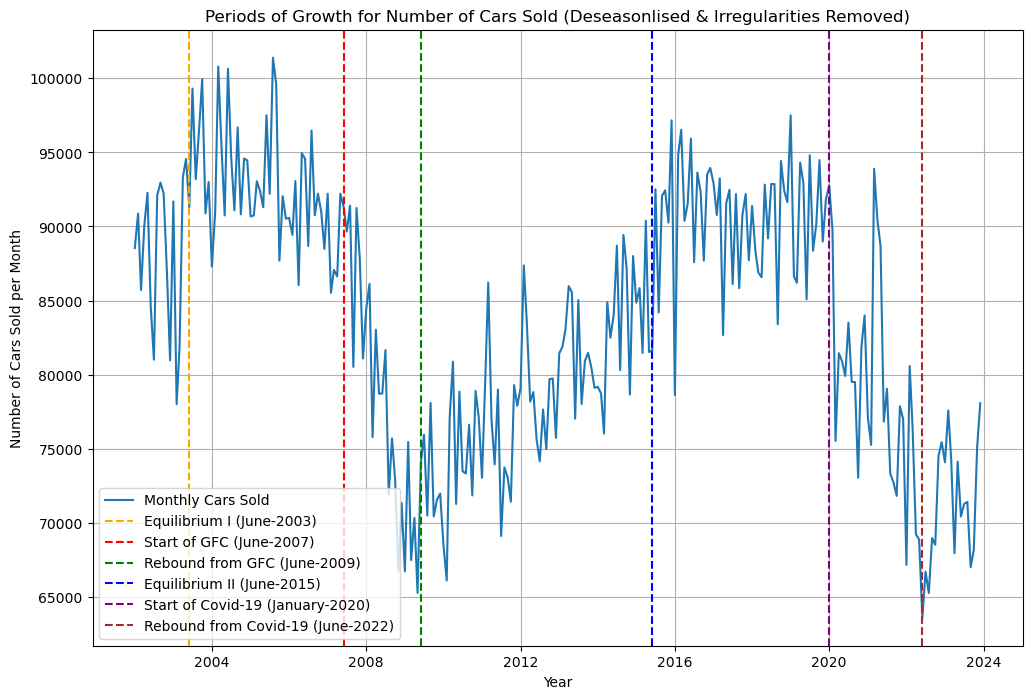

In [35]:
dates = ['2003-06-01','2007-06-01','2009-06-01','2015-06-01','2020-01-01','2022-06-01']
labels = ['Equilibrium I (June-2003)',
          'Start of GFC (June-2007)',
          'Rebound from GFC (June-2009)',
          'Equilibrium II (June-2015)',
          'Start of Covid-19 (January-2020)',
          'Rebound from Covid-19 (June-2022)']
plot_with_annotated_dates(cyclical_cars_sold['date'],cyclical_cars_sold['irregularities_deseasonlised_cars_sold'],
                          labels,dates,'Year','Number of Cars Sold per Month',
                          'Periods of Growth for Number of Cars Sold (Deseasonlised & Irregularities Removed)')

The specific movements have been created based on global events and other periods where the number of cars sold is being changed significantly. These movements will be explored further when looking at chapter 3, in the economic understanding. For now it is going to be assumed that the movement happens on some type of cycle (which is not really the case). However it is a good basis for building future forecasting.

##### Create Yearly Data

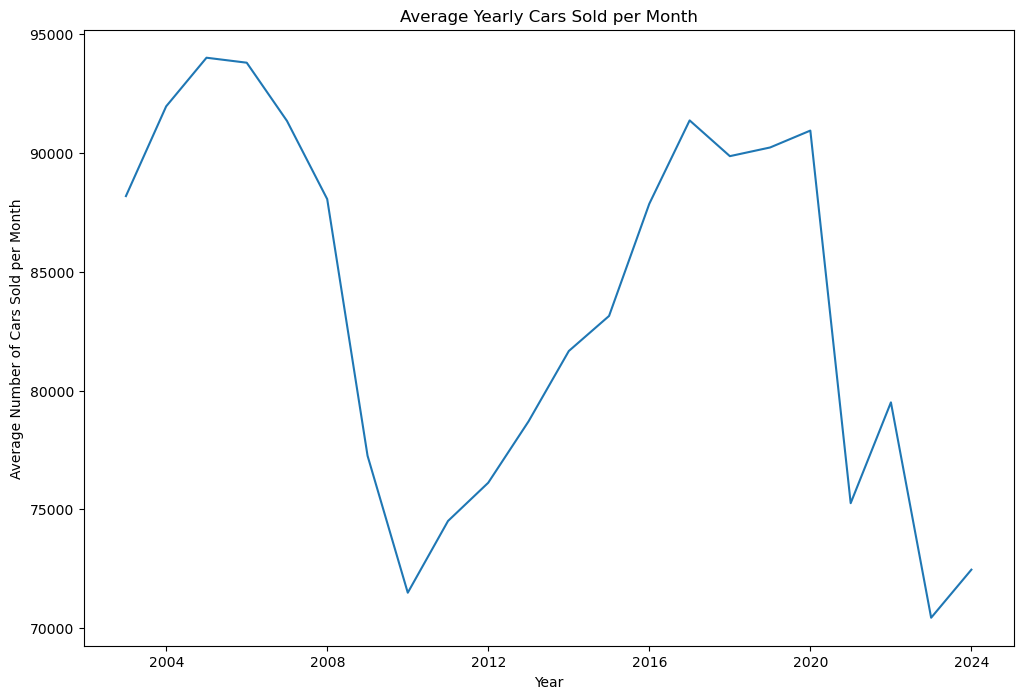

In [36]:
# create yearly data saved as 'yearly_data'
yearly_data = monthly_sales_data.mean(axis=1)

# plot the data with years as the x value
years = pd.date_range(start='2002-01-01',end='2024-01-01',freq='Y')
line_series(years,yearly_data,'Average Yearly Cars Sold per Month','Year','Average Number of Cars Sold per Month')

Observing the average number of cars sold per year and the deseasonlised cars sold per month, there is a clear movement in the data that follows some type of trend. There seems to be some period of stagnent growth with downturns and recoveries based on the economic conditions. This can be graphed by using a sinusoidal graph, this will be used to create the first forecast of data.

##### Create Sinusoidal Graph
- Create yearly sinusoidal graph to capture overall movement
- Create monthly sinusoidal graph to capture the movement with a higher frequency (per month)

Sinusoidal graph equations are made up of 
- Amplitude: The vertical distance between the sinusoidal axis (A)
- Period: The time in between two symmetrical points in a sinusoidal wave (T)
- Vertical Translation: Moving the graphs position above or below 0 (D)
- Horizontal Translation: Moving the graphs position to the left or right of 0 (C)
- Frequency: The number of whole cycles that occur within a time period (B)

In [37]:
# sine function
def sine_function(x, A, B, C, D):
    return A * np.sin(B * (x - C)) + D

##### Create Yearly Sinusoidal Graph
The first peak happens at the mid point of the stagnent period I, which is 2005-06-01.

The second peak happens at the mid point of the stagnent period II, which is 2017-09-01.

That is a time period of (12 years and 9 months, round up to 13 years)

Get 13 years on from the start of the data in 2002 so that goes from 2002 to 2015 and get the data for the sinusoidal movement from that data.

In [38]:
# get the first 13 years of data
thirteen_years_data = yearly_data.iloc[0:13]

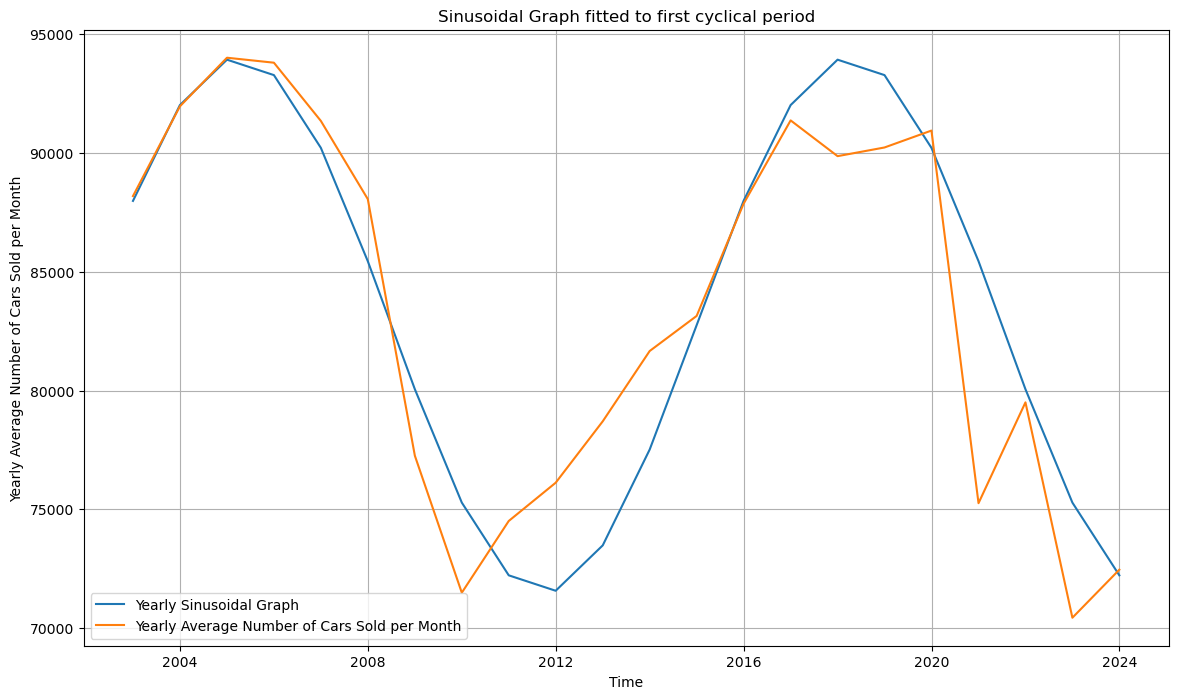

In [39]:
# calculated parameters
A = (thirteen_years_data.max() - thirteen_years_data.min())/2
D = (thirteen_years_data.max() + thirteen_years_data.min())/2
T_yearly = 13 
C = -1 # this is because the sine graph needs to be horizontally translated to the left to match up the time of the sinusoidal period with the data
B_yearly = 2 * np.pi / T_yearly

# x values
x_values_yearly = np.arange(0,len(yearly_data))

# calculate y values
y_values_yearly = sine_function(x_values_yearly, A, B_yearly, C, D)

# plot the difference
plot_multiple_series(years,[y_values_yearly,yearly_data],['Yearly Sinusoidal Graph','Yearly Average Number of Cars Sold per Month'],
                     'Sinusoidal Graph fitted to first cyclical period',
                     'Time','Yearly Average Number of Cars Sold per Month')

##### Create Monthly Sinusoidal Graph

In [40]:
T_monthly = (2018-2006) * 12
B_monthly = 2 * np.pi / T_monthly

x_values_monthly = np.arange(0,len(sales_data))

y_values_monthly = sine_function(x_values_monthly, A, B_monthly, C, D)

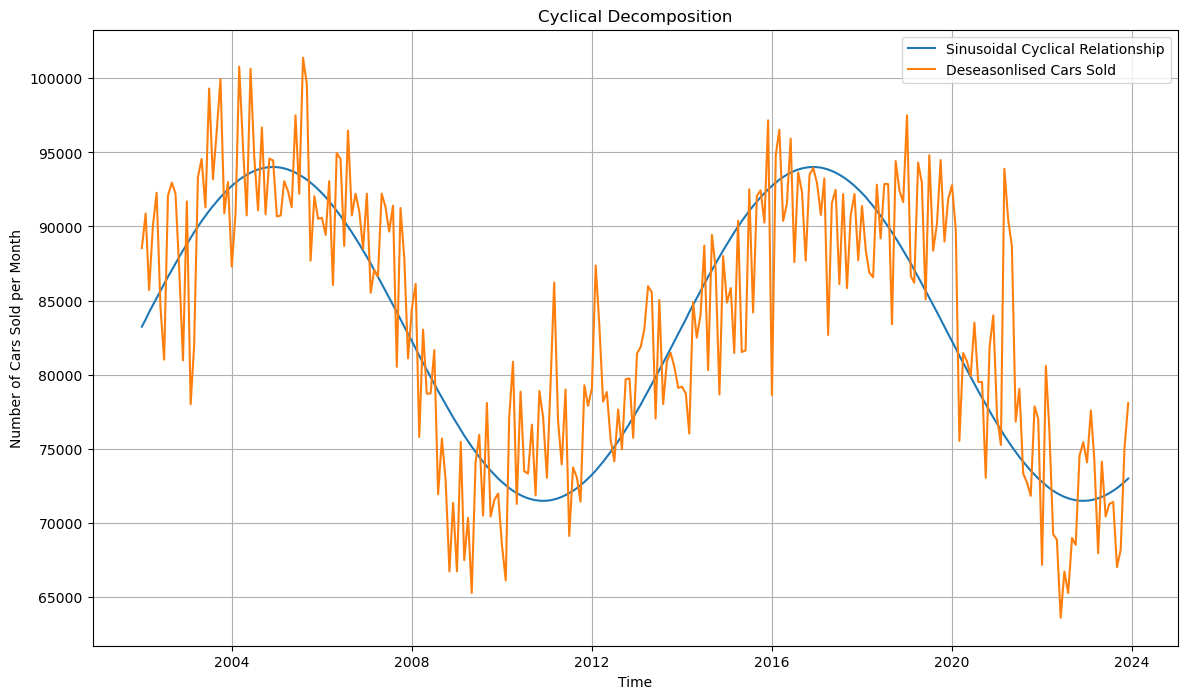

In [41]:
plot_multiple_series(sales_data['date'],[y_values_monthly,irregularities_cars_sold['irregularities_deseasonlised_cars_sold']],
                     ['Sinusoidal Cyclical Relationship','Deseasonlised Cars Sold']
                     ,'Cyclical Decomposition','Time','Number of Cars Sold per Month')

In [42]:
# isolate the cyclical changes
cyclical_cars_sold['cyclical_component'] = y_values_monthly - sales_data['total_cars_sold'].mean()

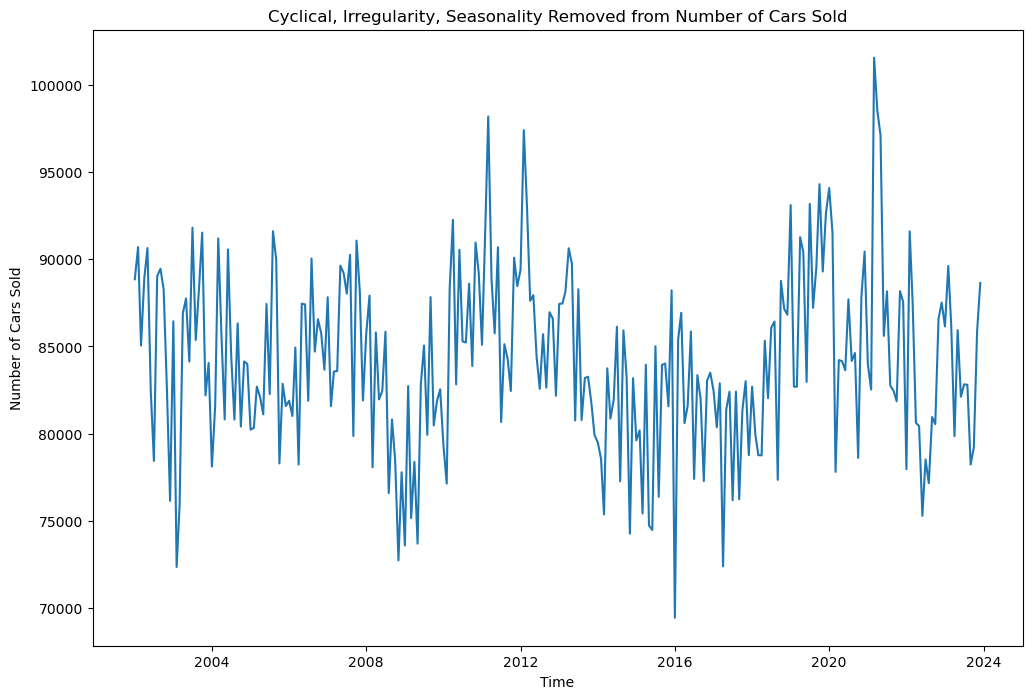

In [43]:
cyclical_cars_sold['irregulrities_deseasonlised_cyclical_cars_sold'] = cyclical_cars_sold['irregularities_deseasonlised_cars_sold'] - cyclical_cars_sold['cyclical_component']
line_series(cyclical_cars_sold['date'],
             cyclical_cars_sold['irregulrities_deseasonlised_cyclical_cars_sold'],
             'Cyclical, Irregularity, Seasonality Removed from Number of Cars Sold','Time','Number of Cars Sold')

In [44]:
#Create a function for a least squares line

#Import the neccessary packages
from sklearn.linear_model import LinearRegression

def least_squares_line(incrementing_value,y_value,title,xlabel,ylabel):
    plt.figure(figsize=(12,8))

    #Create the x and y values for the least squares lines
    x_trend_least_squares = incrementing_value.values.reshape(-1,1).astype(float)
    y_trend_least_squares = y_value.astype(float) 

    #Train the model using linear regression packagage
    model = LinearRegression()

    #Fit the model to the x and y values
    model.fit(x_trend_least_squares,y_trend_least_squares)

    #Create the y values for the least squares
    y_pred = model.predict(x_trend_least_squares)

    plt.scatter(x_trend_least_squares, y_trend_least_squares, label='original data', color='blue')
    plt.plot(x_trend_least_squares, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    #Get the slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept

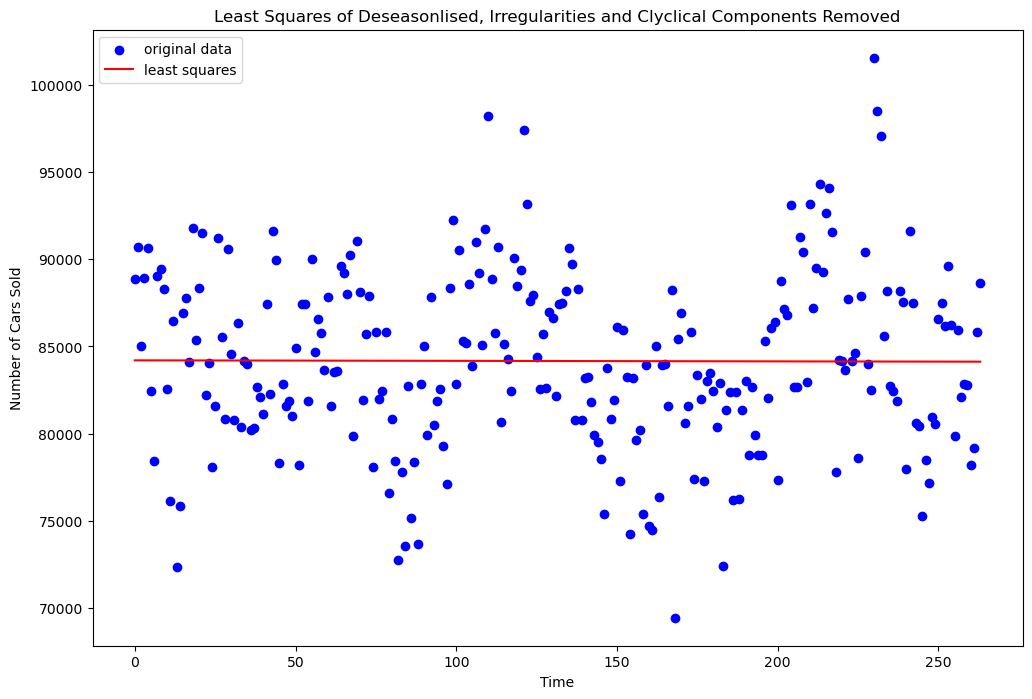

(-0.29524985059399256, 84200.08698743519)

In [45]:
least_squares_line(cyclical_cars_sold.index,cyclical_cars_sold['irregulrities_deseasonlised_cyclical_cars_sold'],'Least Squares of Deseasonlised, Irregularities and Clyclical Components Removed',
                   'Time','Number of Cars Sold')

There is no trend in the data

#### Evaluation of Seasonal Decomposition
The data has been made up of a trend, seasonality component, cyclical component and an average number of cars solds.

By summing these values you get the original data

In [46]:
# create dataframe to store data
seasonal_decomposition = pd.DataFrame()

# get the dates from 2002 january to 2023 december
seasonal_decomposition['date'] = sales_data['date']

# add the seasonality components to the dataframe
seasonal_decomposition['seasonality'] = deseasonlise_cars_sold['seasonal_component']

# add the cyclical component (sinusoidal graph)
seasonal_decomposition['cyclical'] = cyclical_cars_sold['cyclical_component']

# get the average (the straight line of the average number of cars sold)
seasonal_decomposition['average'] = sales_data['total_cars_sold'].mean()

# print the dataframe
seasonal_decomposition

,date,seasonality,cyclical,average
0,2002-01-01,-7505.304167,-312.775940,83554.246212
1,2002-02-01,-12372.354167,177.675615,83554.246212
2,2002-03-01,7308.295833,666.258185,83554.246212
3,2002-04-01,6200.295833,1152.041725,83554.246212
4,2002-05-01,5657.995833,1634.101519,83554.246212
...,...,...,...,...
259,2023-08-01,7192.195833,-11390.113483,83554.246212
260,2023-09-01,2264.895833,-11211.973772,83554.246212
261,2023-10-01,1065.645833,-11014.022202,83554.246212
262,2023-11-01,-10075.254167,-10796.635585,83554.246212


In [47]:
# sum all of these columns together
seasonal_decomposition['total_cars_sold_calculated'] = seasonal_decomposition.sum(axis=1) # axis 1 is going across the row
seasonal_decomposition

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_26732/2844621481.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  seasonal_decomposition['total_cars_sold_calculated'] = seasonal_decomposition.sum(axis=1) # axis 1 is going across the row


,date,seasonality,cyclical,average,total_cars_sold_calculated
0,2002-01-01,-7505.304167,-312.775940,83554.246212,75736.166105
1,2002-02-01,-12372.354167,177.675615,83554.246212,71359.567661
2,2002-03-01,7308.295833,666.258185,83554.246212,91528.800231
3,2002-04-01,6200.295833,1152.041725,83554.246212,90906.583771
4,2002-05-01,5657.995833,1634.101519,83554.246212,90846.343564
...,...,...,...,...,...
259,2023-08-01,7192.195833,-11390.113483,83554.246212,79356.328563
260,2023-09-01,2264.895833,-11211.973772,83554.246212,74607.168273
261,2023-10-01,1065.645833,-11014.022202,83554.246212,73605.869843
262,2023-11-01,-10075.254167,-10796.635585,83554.246212,62682.356461


In [48]:
# create a residual plot of calculated and original number of cars sold
residual = seasonal_decomposition['total_cars_sold_calculated'] - irregularities_cars_sold['irregularities_removed_cars_sold']

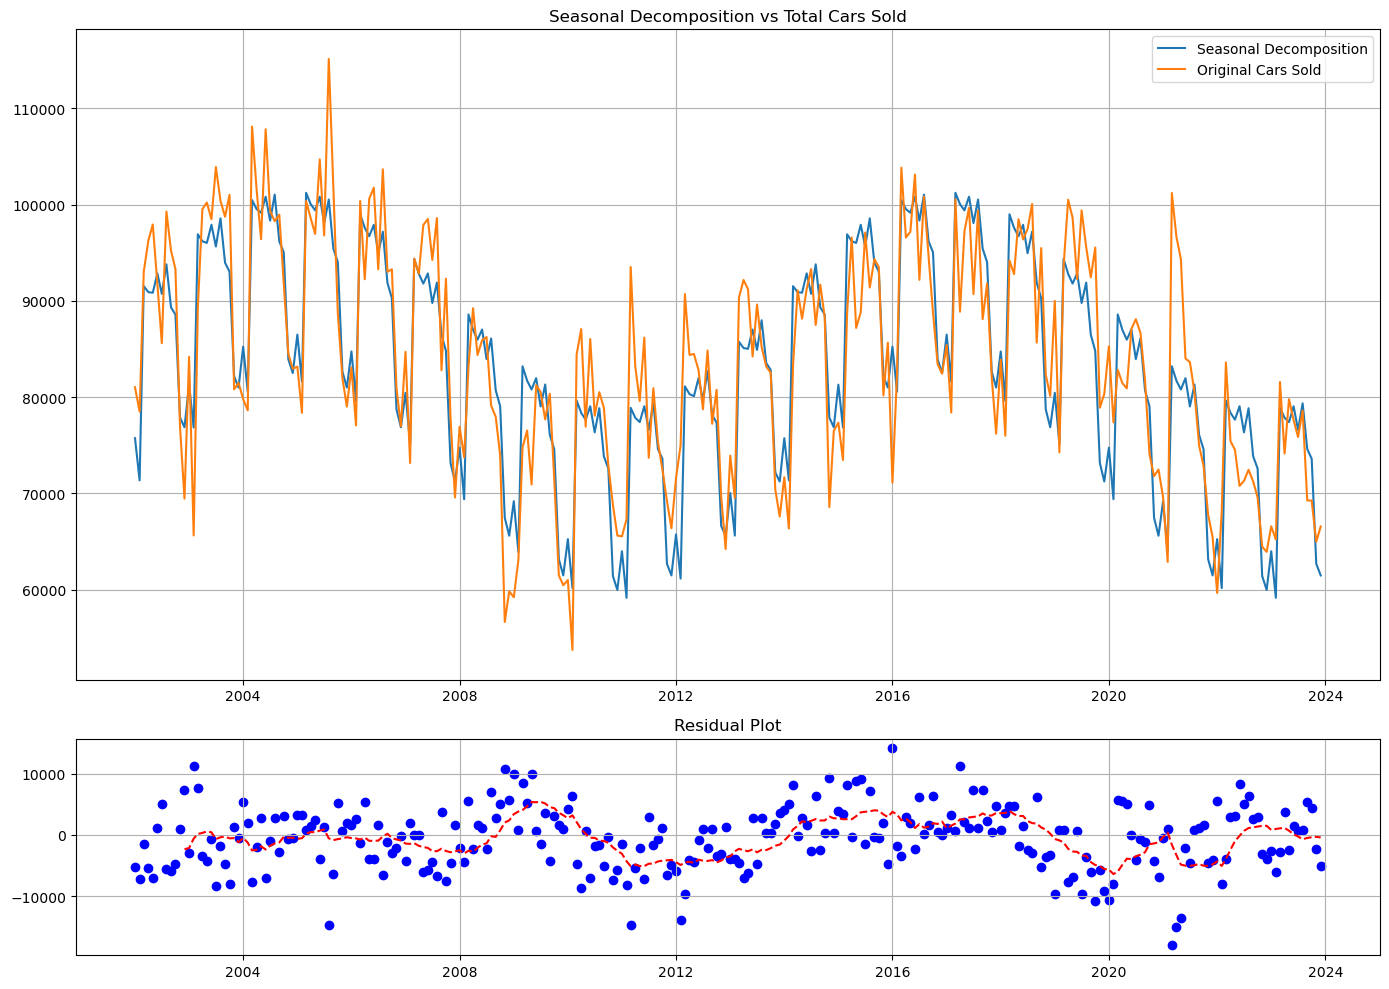

In [49]:
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # Define the grid layout

# Create subplots with the defined grid
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Plot the standard deviation of month to month
ax0.plot(sales_data['date'], seasonal_decomposition['total_cars_sold_calculated'],label='Seasonal Decomposition')
ax0.plot(sales_data['date'], irregularities_cars_sold['irregularities_removed_cars_sold'],label='Original Cars Sold')
ax0.set_title('Seasonal Decomposition vs Total Cars Sold')
ax0.grid()
ax0.legend()

# Plot the standard deviation from year to year
ax1.scatter(sales_data['date'], residual,color='blue')
ax1.set_title('Residual Plot')
ax1.grid()

ax1.plot(sales_data['date'],residual.rolling(12).mean(),color='red',linestyle='--')

plt.tight_layout()
plt.show()

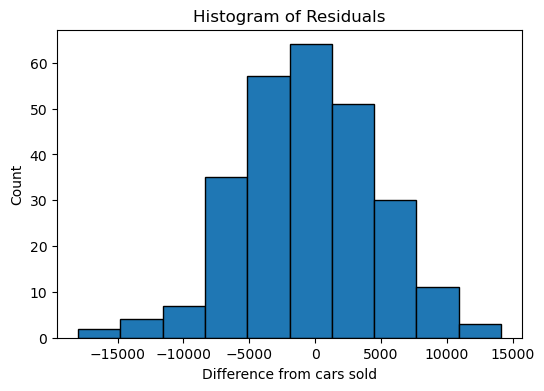

In [50]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_histogram(ax,residual,10,'Histogram of Residuals','Difference from cars sold','Count')

The histogram has a normal distribution. This means that the decomposition has successfully identified the different components that make up the data. This means that the data can be appropriately used for forecasting based on the current model decomposition. Forecasting can then using a normal distribution for predicting future values to create a less accurate but more realsitic understanding of the data's movement. This can also be done using stochasting model where different outcomes are possible. This is going to be further explored when looking to understand the movement that takes place following economic conditions.

#### Forecast Future Number of Cars Sold

In [51]:
# add future row values from 2024-01-01 to 2040-01-01
forecast = pd.DataFrame()
forecast['date'] = pd.date_range(start='2002-01-01',end='2040-01-01',freq='M')
forecast['total_cars_sold'] = sales_data['total_cars_sold']
forecast

,date,total_cars_sold
0,2002-01-31,81033.0
1,2002-02-28,78502.0
2,2002-03-31,93019.0
3,2002-04-30,96269.0
4,2002-05-31,97936.0
...,...,...
451,2039-08-31,NaN
452,2039-09-30,NaN
453,2039-10-31,NaN
454,2039-11-30,NaN


In [52]:
# create seasonality for each month
forecast['month'] = forecast['date'].dt.month_name()
forecast['seasonality'] = forecast['month'].map(monthly_mean_covid_removed)

In [53]:
# create cyclical component for each month
x_values_forecast = np.arange(0,len(forecast))

forecast['cyclical'] = sine_function(x_values_forecast,A,B_monthly,C,D) - sales_data['total_cars_sold'].mean()

In [54]:
# create an average for each month
forecast['average'] = sales_data['total_cars_sold'].mean()
forecast

,date,total_cars_sold,month,seasonality,cyclical,average
0,2002-01-31,81033.0,January,-7505.304167,-312.775940,83554.246212
1,2002-02-28,78502.0,February,-12372.354167,177.675615,83554.246212
2,2002-03-31,93019.0,March,7308.295833,666.258185,83554.246212
3,2002-04-30,96269.0,April,6200.295833,1152.041725,83554.246212
4,2002-05-31,97936.0,May,5657.995833,1634.101519,83554.246212
...,...,...,...,...,...,...
451,2039-08-31,NaN,August,7192.195833,7825.583121,83554.246212
452,2039-09-30,NaN,September,2264.895833,8133.226951,83554.246212
453,2039-10-31,NaN,October,1065.645833,8423.857951,83554.246212
454,2039-11-30,NaN,November,-10075.254167,8696.922889,83554.246212


In [55]:
# create single column
forecast['forecast'] = forecast['average'] + forecast['cyclical'] + forecast['seasonality']
forecast

,date,total_cars_sold,month,seasonality,cyclical,average,forecast
0,2002-01-31,81033.0,January,-7505.304167,-312.775940,83554.246212,75736.166105
1,2002-02-28,78502.0,February,-12372.354167,177.675615,83554.246212,71359.567661
2,2002-03-31,93019.0,March,7308.295833,666.258185,83554.246212,91528.800231
3,2002-04-30,96269.0,April,6200.295833,1152.041725,83554.246212,90906.583771
4,2002-05-31,97936.0,May,5657.995833,1634.101519,83554.246212,90846.343564
...,...,...,...,...,...,...,...
451,2039-08-31,NaN,August,7192.195833,7825.583121,83554.246212,98572.025167
452,2039-09-30,NaN,September,2264.895833,8133.226951,83554.246212,93952.368996
453,2039-10-31,NaN,October,1065.645833,8423.857951,83554.246212,93043.749996
454,2039-11-30,NaN,November,-10075.254167,8696.922889,83554.246212,82175.914934


In [56]:
# create a forecast column
forecast['forecast'].iloc[0:264] = 0
forecast['future sales'] = forecast['forecast']+forecast['total_cars_sold'].replace(np.nan,0)
forecast

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_26732/3504393930.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['forecast'].iloc[0:264] = 0


,date,total_cars_sold,month,seasonality,cyclical,average,forecast,future sales
0,2002-01-31,81033.0,January,-7505.304167,-312.775940,83554.246212,0.000000,81033.000000
1,2002-02-28,78502.0,February,-12372.354167,177.675615,83554.246212,0.000000,78502.000000
2,2002-03-31,93019.0,March,7308.295833,666.258185,83554.246212,0.000000,93019.000000
3,2002-04-30,96269.0,April,6200.295833,1152.041725,83554.246212,0.000000,96269.000000
4,2002-05-31,97936.0,May,5657.995833,1634.101519,83554.246212,0.000000,97936.000000
...,...,...,...,...,...,...,...,...
451,2039-08-31,NaN,August,7192.195833,7825.583121,83554.246212,98572.025167,98572.025167
452,2039-09-30,NaN,September,2264.895833,8133.226951,83554.246212,93952.368996,93952.368996
453,2039-10-31,NaN,October,1065.645833,8423.857951,83554.246212,93043.749996,93043.749996
454,2039-11-30,NaN,November,-10075.254167,8696.922889,83554.246212,82175.914934,82175.914934


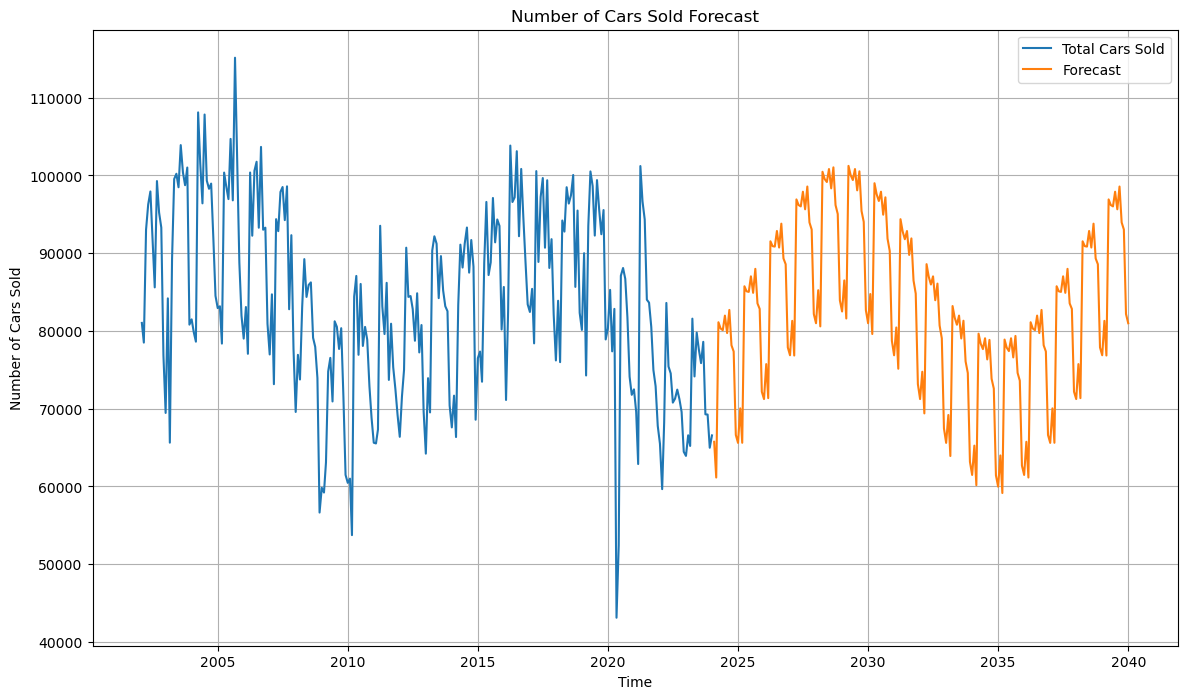

In [57]:
# plot the forecasted data and the number of cars sold
plot_multiple_series(forecast['date'],[forecast['total_cars_sold'],forecast['forecast'].replace(0,np.nan)],
                     ['Total Cars Sold','Forecast'],'Number of Cars Sold Forecast','Time','Number of Cars Sold')

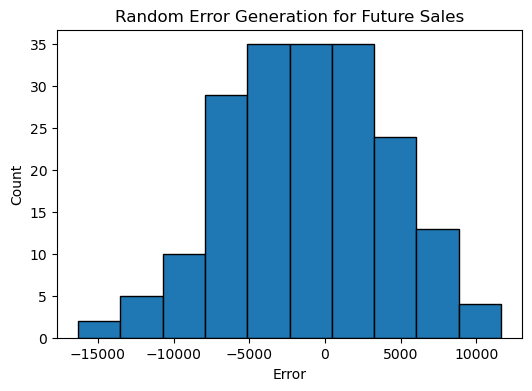

In [68]:
random_error = pd.Series(generate_numbers_from_distribution('normal',(0,residual.std()),(2+(2040-2024)*12),residual.min(),residual.max(),12))
fig, ax = plt.subplots(figsize=(6, 4))
plot_histogram(ax,random_error,10,'Random Error Generation for Future Sales','Error','Count')

In [59]:
forecast['errors'] = np.nan
forecast['errors'].iloc[264:] = random_error
forecast

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_26732/233117627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast['errors'].iloc[264:] = random_error


,date,total_cars_sold,month,seasonality,cyclical,average,forecast,future sales,errors
0,2002-01-31,81033.0,January,-7505.304167,-312.775940,83554.246212,0.000000,81033.000000,NaN
1,2002-02-28,78502.0,February,-12372.354167,177.675615,83554.246212,0.000000,78502.000000,NaN
2,2002-03-31,93019.0,March,7308.295833,666.258185,83554.246212,0.000000,93019.000000,NaN
3,2002-04-30,96269.0,April,6200.295833,1152.041725,83554.246212,0.000000,96269.000000,NaN
4,2002-05-31,97936.0,May,5657.995833,1634.101519,83554.246212,0.000000,97936.000000,NaN
...,...,...,...,...,...,...,...,...,...
451,2039-08-31,NaN,August,7192.195833,7825.583121,83554.246212,98572.025167,98572.025167,1469.648452
452,2039-09-30,NaN,September,2264.895833,8133.226951,83554.246212,93952.368996,93952.368996,-2022.635702
453,2039-10-31,NaN,October,1065.645833,8423.857951,83554.246212,93043.749996,93043.749996,-11162.645102
454,2039-11-30,NaN,November,-10075.254167,8696.922889,83554.246212,82175.914934,82175.914934,-6709.034507


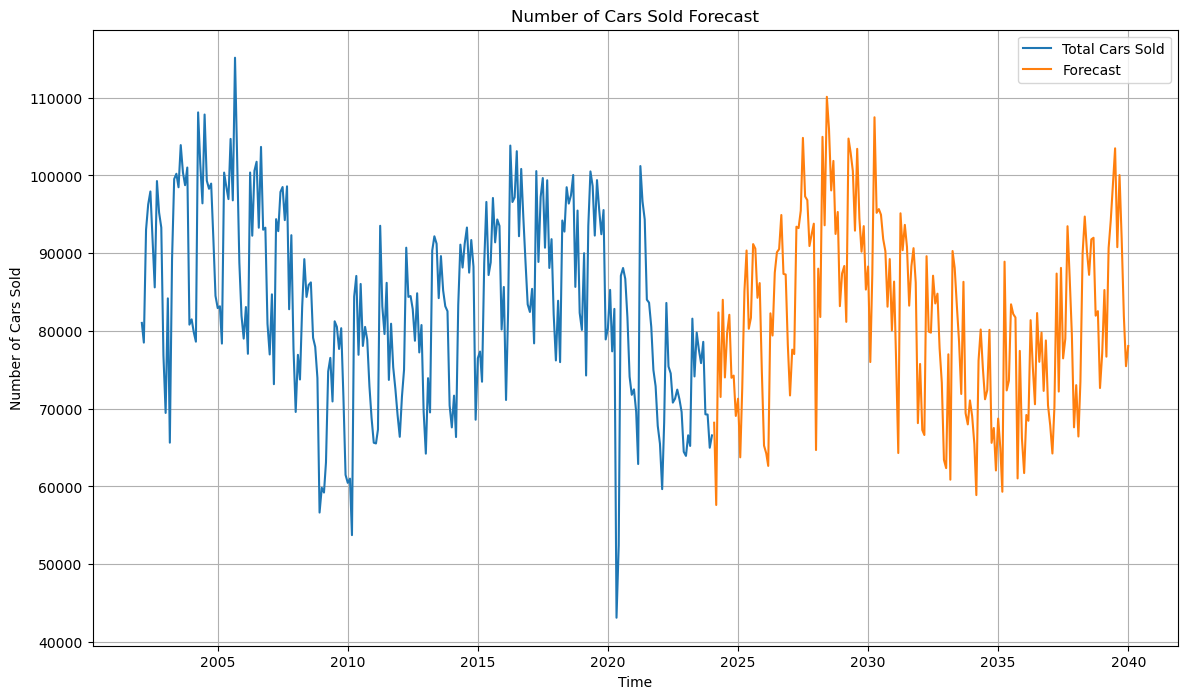

In [67]:
# create future sales with error
forecast['future_sales_with_error'] = forecast['future sales']+forecast['errors'].replace(np.nan,0)
plot_multiple_series(forecast['date'],[forecast['total_cars_sold'],(forecast['errors'].replace(0,np.nan)+forecast['future sales'])],
                     ['Total Cars Sold','Forecast'],'Number of Cars Sold Forecast','Time','Number of Cars Sold')

##### Prediction & Confidence Intervals

#### Train/Test Forecast
It is good to prove that you can use two years of cycle which is accurate to what happens, the next challenge is to look at the movement that takes place from one economic cycle and generalise it. This is so that data can follow a particular movement when a major economic event such as Covid-19 or the Global Financial Crises takes place. So far the only recovery that has taken place has been observed following the GFC as the recovery from Covid-19 according to the above table is only going to begin happening now.

### SARIMA Predictions
As there was a clear indication of a seasonal component, AR, MA, ARMA and ARIMA models are not going to be as accurate as those that include their seasonal components. I am going to use the deseasonilised data to then perform an ARIMA.

#### Moving Average
The moving average can be determined by looking at the ACF plot.

ACF plot - Is looking at the moving average nature of the graph, this is how much values from lag k-1 impact lag k.

In [ ]:
acf_total_cars_sold = plot_acf(components_removed['total_cars_sold'],
                               title='Autocorrelation of Total Cars Sold')

NameError: name 'components_removed' is not defined

In [ ]:
q_cars_sold = [1,12]

The autocorrelation of total cars sold without deseasonlisation shows that there is cycle where every 12 months there is an increase in the autocorrelation. This is the moving average meaning that every 12 units there is a strong cyclical period which is what was suggested took place through the seasonal decomposition above. Deseasonlising the data then looking at the moving average will help determine appropriate moving average values (q).

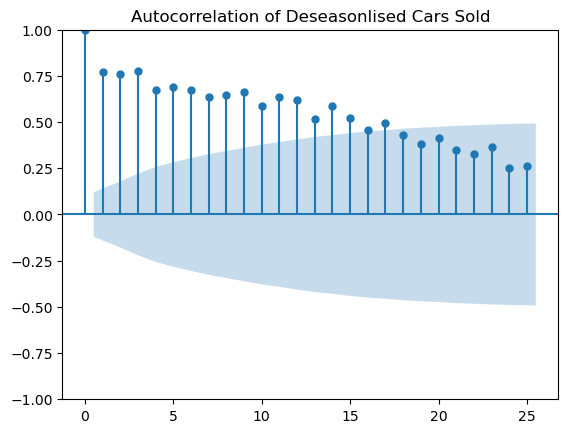

In [ ]:
acf_deseasonlised_cars_sold = plot_acf(irregularities_cars_sold['irregularities_deseasonlised_cars_sold']'],
                                       title='Autocorrelation of Deseasonlised Cars Sold')

After deseasonilising the data notice that the moving average follows no cycle and just has a trend which is decreasing. This is a good sign which suggests that the seasonal component has appropriately been removed.

In [ ]:
q_deseasonlised_cars_sold = [1,2,3]

#### Auto Regressive
The autoregressive plot is found by looking at the PACF plot.

PACF plot - Is looking at the autoregressive nature of the graph, this is how values from lag k impact the current value

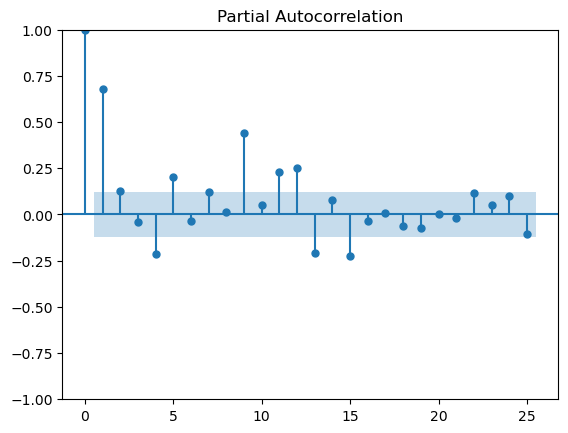

In [ ]:
pacf_cars_sold = plot_pacf(sales_data['total_cars_sold'])

In [ ]:
p_cars_sold = [1,4,9]

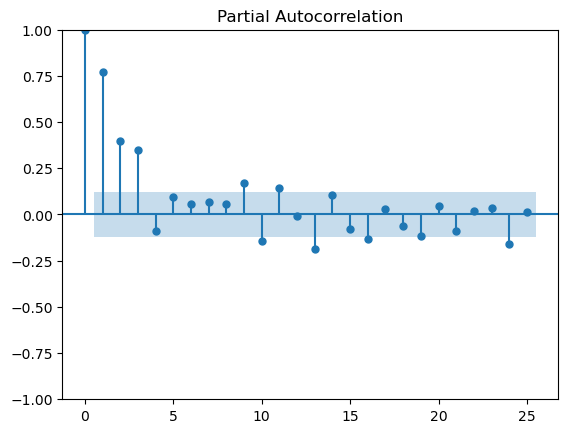

In [ ]:
pacf_cars_sold_deseasonlised = plot_pacf(irregularities_cars_sold['irregularities_deseasonlised_cars_sold']'])

In [ ]:
p_deseasonlised_cars_sold = [1,2]

#### Integrated - Testing for Stationarity
The goal of the ARIMA modeling is to have a stationary graph. This happens when there is no direct relationship between time and the value of cars sold. Stationarity would happen once all of the components have been taking a part from the movement of the graph.

In [ ]:
adf_test(sales_data['total_cars_sold'])

ADF Statistic:  -1.4184351403324917
P-Value:  0.5734068692666414
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


In [ ]:
adf_test(sales_data['total_cars_sold'].diff().dropna())

ADF Statistic:  -5.458550595824889
P-Value:  2.549064175329441e-06
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


In [ ]:
d_cars_sold = [1]

In [ ]:
adf_test(irregularities_cars_sold['irregularities_deseasonlised_cars_sold']'])

ADF Statistic:  -1.6284107733064388
P-Value:  0.46832268707907093
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


In [ ]:
adf_test(irregularities_cars_sold['irregularities_deseasonlised_cars_sold']'].diff().dropna())

ADF Statistic:  -3.908444806107928
P-Value:  0.0019735695469819486
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


In [ ]:
d_deseasonlised_cars_sold = [1]

In [ ]:
select_best_sarima_model(sales_data['total_cars_sold'],p_cars_sold,d_cars_sold,q_cars_sold,p_deseasonlised_cars_sold,d_deseasonlised_cars_sold,q_deseasonlised_cars_sold,12)

{'aic': 5194.6894192655855,
 'bic': 5205.26577808298,
 'pdq': (0, 1, 1),
 'seasonal_pdq': (0, 1, 1, 12)}

In [ ]:
evaluate_time_series_models(irregularities_cars_sold['irregularities_deseasonlised_cars_sold']'],p_deseasonlised_cars_sold,q_deseasonlised_cars_sold,d_deseasonlised_cars_sold)

,Model,Order,AIC,BIC
10,ARMA,"(2, 0, 3)",5232.962048,5257.993692
9,ARMA,"(2, 0, 2)",5235.627911,5257.083606
5,ARMA,"(1, 0, 1)",5238.400201,5252.703998
8,ARMA,"(2, 0, 1)",5240.016972,5257.896717
6,ARMA,"(1, 0, 2)",5240.882811,5258.762556
7,ARMA,"(1, 0, 3)",5241.815301,5263.270995
1,AR,"(2, 0, 0)",5266.139558,5280.443354
12,ARIMA,"(1, 1, 2)",5275.379865,5289.668481
14,ARIMA,"(2, 1, 1)",5275.498086,5289.786702
15,ARIMA,"(2, 1, 2)",5278.300698,5296.161468


The above gives a list of different models including AR, MA, ARMA and ARIMA. 

ARMA has the lowest AIC and BIC this is because the data does not to be differenced to reduce the error. Meaning that with a p order o2 and q order of 3 is relatively stationary.

#### ARIMA/SARIMA Model Diagnostics

In [ ]:
# create the model
model = SARIMAX(sales_data['total_cars_sold'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29393D+00    |proj g|=  1.03091D-01

At iterate    5    f=  9.28198D+00    |proj g|=  4.12292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   4.313D-05   9.282D+00
  F =   9.2819828834792997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                    total_c

 This problem is unconstrained.


Major economic events have been included in this graph. It displays how responsive the automotive industry is to economic changes. This means that economic data needs to be explored further to understand the movement of car sales in Maryland. 

During major economic events the following changes
- Economic activity including business capital investment and consumer expenditure
- Employment Level (hours worked and unemployment) 
- Inflation rates

In [ ]:
# create dataframe with date
economic_data = pd.DataFrame({'date':pd.date_range(start='2002-01-01',end='2024-01-01',freq='Y')})

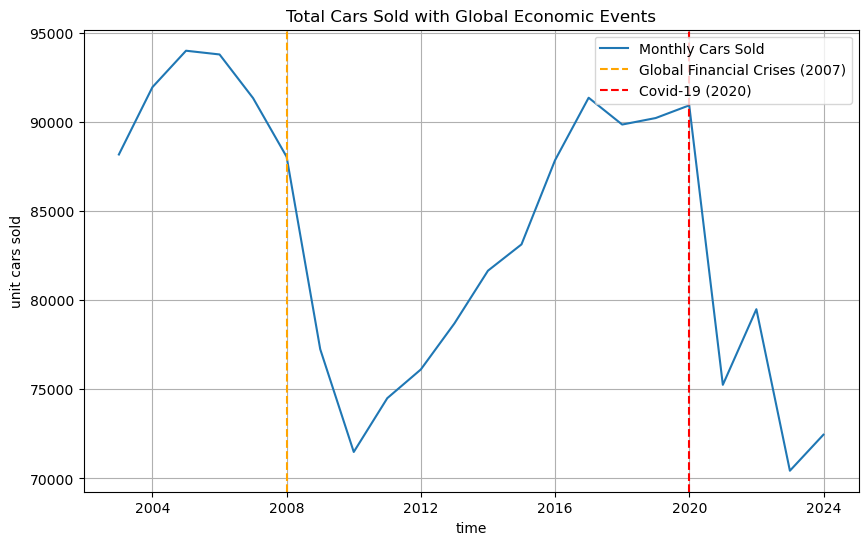

In [ ]:
years = pd.date_range(start='2002-01-01',end='2024-01-01',freq='Y')
plot_with_annotated_dates(years,monthly_sales_data.mean(axis=1),['Global Financial Crises (2007)','Covid-19 (2020)'],
                          ['2008-01-01','2020-01-01'],'time','unit cars sold','Total Cars Sold with Global Economic Events')

In [ ]:
economic_data['mean_total_cars_sold'] = monthly_sales_data.mean(axis=1)
economic_data

,date,mean_total_cars_sold
0,2002-12-31,88187.750000
1,2003-12-31,91967.500000
2,2004-12-31,94015.416667
3,2005-12-31,93805.750000
4,2006-12-31,91354.166667
5,2007-12-31,88061.083333
6,2008-12-31,77253.666667
7,2009-12-31,71484.750000
8,2010-12-31,74505.583333
9,2011-12-31,76116.416667


### Holt Winter's Prediction